Mounted at /content/drive

🚀 Hugging Face에서 데이터셋을 다운로드합니다... (daekeun-ml/naver-news-summarization-ko)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/787 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/66.3M [00:00<?, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/22194 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2466 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2740 [00:00<?, ? examples/s]

✅ 원본 데이터 로드 완료: 22194건
🧹 데이터 정제(Preprocessing)를 수행합니다...
   - [제거] 요약문 > 본문: 1739건
   - [제거] 본문 < 50자: 0건
✅ 최종 학습용 데이터: 20455건
📊 데이터 분할 완료: Train(16364), Val(2045), Test(2046)
✅ Test Dataset 저장 완료: /content/drive/MyDrive/NLP_Assignment5/data/test_dataset.csv

🤖 모델 로드 중: gogamza/kobart-summarization


config.json: 0.00B [00:00, ?B/s]

You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.
You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

🔄 데이터 토큰화 진행 중...


Map:   0%|          | 0/16364 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4118: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2045 [00:00<?, ? examples/s]

/tmp/ipython-input-3330436191.py:173: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(



🚀 학습 시작...


Epoch,Training Loss,Validation Loss,Rougel
1,0.462900,0.463863,34.984800
2,0.381700,0.441361,34.395800
3,0.276500,0.445003,34.866600



💾 모델 저장 중...
✅ 모델 저장 완료: /content/drive/MyDrive/NLP_Assignment5/final_model

📈 학습 곡선 시각화 생성 중...


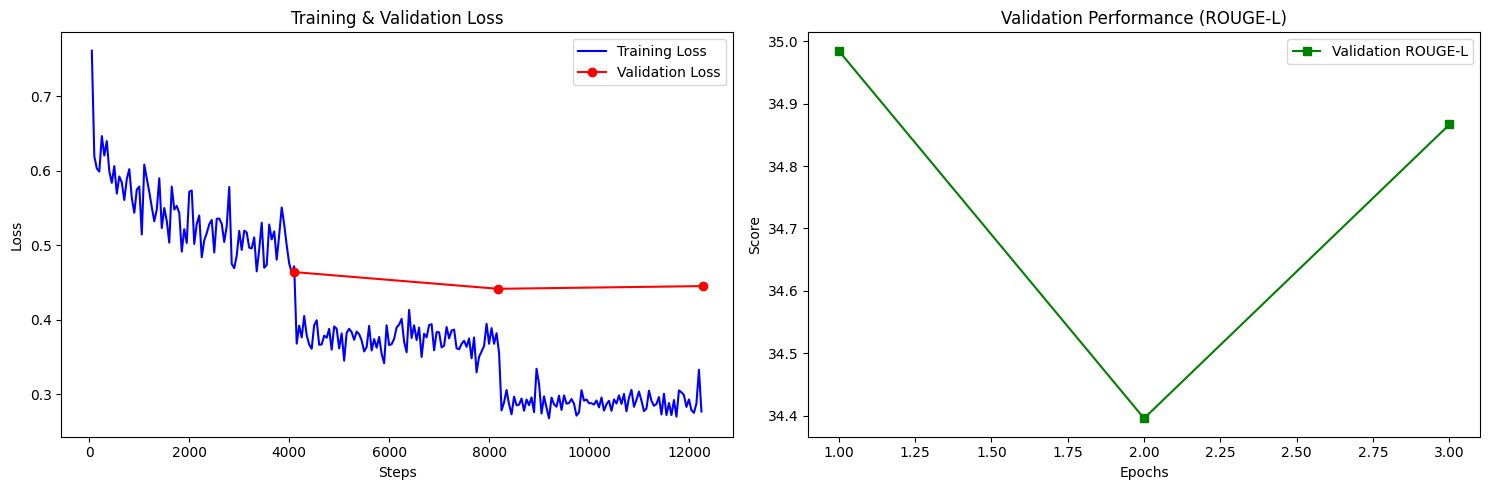

✅ 학습 곡선 이미지가 저장되었습니다: /content/drive/MyDrive/NLP_Assignment5/plots/learning_curve.png


In [1]:
# -*- coding: utf-8 -*-

"""
[Assignment 5] Training Notebook
- 데이터 로드 (Hugging Face) 및 자동 전처리
- Train/Validation/Test 분할
- KoBART 모델 Fine-tuning
- 학습 과정 시각화 (Loss & ROUGE Score)
- 모델 가중치 및 Test 데이터셋 저장 (Google Drive)
"""

# ==========================================
# 1. 환경 설정 및 라이브러리 설치
# ==========================================
import os
import sys
import subprocess

# 필수 라이브러리 설치 (evaluate 추가됨)
packages = ["transformers", "datasets", "accelerate", "rouge-score", "scikit-learn", "matplotlib", "evaluate"]
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

from google.colab import drive
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
# [수정] load_metric 제거, evaluate 임포트
from datasets import Dataset, load_dataset
import evaluate
import numpy as np

# Google Drive 마운트
drive.mount('/content/drive')

# 저장 경로 설정
PROJECT_DIR = "/content/drive/MyDrive/NLP_Assignment5"
MODEL_SAVE_DIR = os.path.join(PROJECT_DIR, "final_model")
DATA_SAVE_DIR = os.path.join(PROJECT_DIR, "data")
PLOT_SAVE_DIR = os.path.join(PROJECT_DIR, "plots") # 시각화 저장 경로

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(DATA_SAVE_DIR, exist_ok=True)
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)


# ==========================================
# 2. 데이터 로드 및 전처리 (Hugging Face)
# ==========================================
print("\n🚀 Hugging Face에서 데이터셋을 다운로드합니다... (daekeun-ml/naver-news-summarization-ko)")

# 1. 데이터셋 로드
dataset = load_dataset("daekeun-ml/naver-news-summarization-ko", split="train")
df = pd.DataFrame(dataset)

print(f"✅ 원본 데이터 로드 완료: {len(df)}건")

# 2. 데이터 정제 (Preprocessing)
print("🧹 데이터 정제(Preprocessing)를 수행합니다...")
initial_count = len(df)

# (1) 길이 계산
df['doc_len'] = df['document'].apply(len)
df['sum_len'] = df['summary'].apply(len)

# (2) 필터링: 요약문이 본문보다 긴 경우 제거 (Logic Error)
df_clean = df[df['sum_len'] <= df['doc_len']].copy()
removed_logic = initial_count - len(df_clean)

# (3) 필터링: 본문이 50자 미만인 초단문 데이터 제거 (Noise)
df_clean = df_clean[df_clean['doc_len'] >= 50].copy()
removed_short = (initial_count - removed_logic) - len(df_clean)

print(f"   - [제거] 요약문 > 본문: {removed_logic}건")
print(f"   - [제거] 본문 < 50자: {removed_short}건")
print(f"✅ 최종 학습용 데이터: {len(df_clean)}건")

# 필요한 컬럼만 유지
df = df_clean[['document', 'summary']]

# 데이터 샘플링 (시간 관계상 3000개만 사용, 필요시 주석 해제)
# df = df.sample(3000, random_state=42)

# 3. 데이터 분할: Train(80%) / Val(10%) / Test(10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"📊 데이터 분할 완료: Train({len(train_df)}), Val({len(val_df)}), Test({len(test_df)})")

# Test Set 저장 (Evaluation 단계용)
test_df.to_csv(os.path.join(DATA_SAVE_DIR, "test_dataset.csv"), index=False)
print(f"✅ Test Dataset 저장 완료: {os.path.join(DATA_SAVE_DIR, 'test_dataset.csv')}")

# Dataset 객체로 변환
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)


# ==========================================
# 3. 모델 준비 및 전처리
# ==========================================
model_name = "gogamza/kobart-summarization"
print(f"\n🤖 모델 로드 중: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def preprocess_function(examples):
    inputs = examples["document"]
    targets = examples["summary"]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("🔄 데이터 토큰화 진행 중...")
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)


# ==========================================
# 4. 학습 (Training) with Metrics
# ==========================================
# [수정] ROUGE 점수를 학습 중에(Validation) 계산하기 위한 함수 (evaluate 라이브러리 사용)
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # ROUGE-L의 F-measure만 추출
    result = {key: value * 100 for key, value in result.items() if key == 'rougeL'}
    # evaluate 라이브러리는 rougeL 점수를 바로 float으로 반환하거나 dict로 반환할 수 있음
    # 만약 결과가 딕셔너리가 아니라면 그대로 사용

    # 보통 evaluate의 rouge 결과는 {'rouge1': 0.x, ...} 형태임
    return {k: round(v, 4) for k, v in result.items()}

batch_size = 4
args = Seq2SeqTrainingArguments(
    output_dir=MODEL_SAVE_DIR,
    eval_strategy="epoch",            # [수정] evaluation_strategy -> eval_strategy 로 변경
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=3,               # 3 Epoch
    predict_with_generate=True,       # Validation 때 생성 모델 사용 (ROUGE 계산용)
    fp16=torch.cuda.is_available(),
    logging_dir='./logs',
    logging_steps=50,                 # 50 step마다 Loss 기록 (그래프용)
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics   # Validation 시 ROUGE 계산
)

print("\n🚀 학습 시작...")
train_result = trainer.train()


# ==========================================
# 5. 모델 저장
# ==========================================
print("\n💾 모델 저장 중...")
trainer.save_model(MODEL_SAVE_DIR)
tokenizer.save_pretrained(MODEL_SAVE_DIR)
print(f"✅ 모델 저장 완료: {MODEL_SAVE_DIR}")


# ==========================================
# [Step 6] 학습 과정 시각화 (Learning Curve) - 필수!
# ==========================================
print("\n📈 학습 곡선 시각화 생성 중...")

# 로그에서 기록 가져오기
history = trainer.state.log_history

# 1. Training Loss
train_loss = [x['loss'] for x in history if 'loss' in x]
steps = [x['step'] for x in history if 'loss' in x]

# 2. Validation Loss & ROUGE
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
val_rougeL = [x['eval_rougeL'] for x in history if 'eval_rougeL' in x]
val_epochs = [x['epoch'] for x in history if 'eval_loss' in x]

# 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# (1) Loss Curve
ax[0].plot(steps, train_loss, label='Training Loss', color='blue')
# Validation Loss는 Epoch 단위로 찍히므로 step과 맞추거나 별도 표시
if val_loss:
    # Validation이 찍힌 step 찾기
    val_steps = [x['step'] for x in history if 'eval_loss' in x]
    ax[0].plot(val_steps, val_loss, label='Validation Loss', color='red', marker='o')

ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Loss')
ax[0].legend()

# (2) Validation ROUGE Score
if val_rougeL:
    ax[1].plot(val_epochs, val_rougeL, label='Validation ROUGE-L', color='green', marker='s')
    ax[1].set_title('Validation Performance (ROUGE-L)')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Score')
    ax[1].legend()

plt.tight_layout()
plt.show()

# 그래프 이미지 저장 (보고서용)
plot_path = os.path.join(PLOT_SAVE_DIR, "learning_curve.png")
fig.savefig(plot_path)
print(f"✅ 학습 곡선 이미지가 저장되었습니다: {plot_path}")